# <center><font color='#4792B1'>**Data Analysis III. - Assignment 2.**</font></center>
# <center><font color='#4792B1'>**Predicting Fast Growing Firms**</font></center>

# <font color='#4792B1'>**Authors:**</font>
- Ghadena Hgaig
- Péter Bence Török


# TO DO: ghadena 
- annotate notebook 
- add AUC interpretation to markdown for 1. 
- re write calssification markdown
_ done: redoing the loss function to optimise the confusion matrix 
- fix why predicting on hold out eith rf mdoel gave us the same probability
- create confusion tables and discuss results of best model 
- do visuals - ROC and calibration curve, what is a loss plot? 

finished: 
- clean code and add markdowns 
- do cv rmse and cv auc 
- do summary table for n coeffs, cv rmse, cv auc & pick best model M4 logit 
- come up with loss function 
- For each model:
Predict probabilities.
Look for the optimal classification threshold.
Calculate expected loss with your loss function.
Pick the model that has the smallest average (over 5 folds) expected loss.
- add markdown for classification part and anlyse findings 
- why is expected loss for lasso and logit so high? 

## 📌 Importing packages and defining helper functions 

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

# ✅ Redirect stderr to suppress printed warnings
sys.stderr = open('/dev/null', 'w')
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")


/opt/anaconda3/envs/C2/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/opt/anaconda3/envs/C2/lib/python3.12/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/opt/anaconda3/envs/C2/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/opt/anaconda3/envs/C2/lib/python3.12/site-packages/sklearn/utils/optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/opt/anaconda3/envs/C2/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(

In [2]:
# ----------------------------
# 📌 Defining helper functions 
# ----------------------------

color = ['blue', 'red', 'green','purple']

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=np.arange(0, 1.1, 0.1))
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

def create_calibration_plot(
    data_holdout,
    file_name="calibration_plot",
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    """
    Generates a calibration plot to compare predicted probabilities vs. actual event probabilities.
    
    Parameters:
    - data_holdout (pd.DataFrame): The dataset containing predicted probabilities and actual outcomes.
    - file_name (str): The name for saving the figure (default: "calibration_plot").
    - prob_var (str): Column name for predicted probabilities.
    - actual_var (str): Column name for actual binary outcomes (0 or 1).
    - y_lab (str): Label for the y-axis (default: "Actual event probability").
    - n_bins (int): Number of bins for grouping predictions into probability intervals (default: 10).
    - breaks (list or None): Custom bin edges if specified (default: None).

    Returns:
    - Displays and saves the calibration plot as an image.
    """
    
    # Ensure valid probability values (between 0 and 1)
    data_holdout = data_holdout[(data_holdout[prob_var] >= 0) & (data_holdout[prob_var] <= 1)]
    
    # Compute the calibration curve (fraction of positives per bin)
    actual, predicted = calibration_curve(
        data_holdout[actual_var], data_holdout[prob_var], n_bins=n_bins, strategy="quantile"
    )
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(predicted, actual, marker="o", linestyle="-", label="Calibration curve")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")  # 45-degree line
    
    # Labels and title
    plt.xlabel("Predicted probability")
    plt.ylabel(y_lab)
    plt.title("Calibration Curve: Estimated vs. Actual Probabilities")
    plt.legend()
    
    # Save and show plot
    plt.savefig(f"{file_name}.png", dpi=300, bbox_inches="tight")
    plt.show()


## 📌 Import Data

### Importing and Cleaning Data
We imported the **cleaned dataset** from the preprocessing step, ensuring it was **free of missing values** and well-structured for analysis. Below are the key **data cleaning, label engineering, and transformation steps** performed.

---

### 🔹 Data Cleaning Steps
- **Handled missing values:**
  - **Dropped variables** with excessive missing values.
  - **Added missing year-firm (`year`, `comp_id`) combinations**, ensuring each firm has an entry for every year.
- **Performed label engineering**:
  - **Created the target variable (`fast_growth`)** based on firm sales growth.
- **Removed potential data leakage**:
  - **Dropped log-transformed sales lag variables and the winsorized sales growth version** to ensure no future data influenced the model.
  - **Filtered the dataset to include only 2012** to prevent unintended information leakage from future observations.

---

### 🔹 Creating the Target Variable: Fast Growth
The **target variable (`fast_growth`)** was constructed based on the **year-over-year sales growth** of firms. We define a firm as **"fast-growing"** if its **log sales growth exceeds 20%**. 

#### **📌 Why 20%?**
- This **threshold aligns with the OECD definition of high-growth firms**, making our model **comparable to economic research**.
- It captures **firms growing at an economically significant rate** while excluding minor fluctuations.
- We measure **growth over one year (2012 to 2013)** rather than two years to:
  - **Capture more recent expansion trends.**
  - **Retain a larger sample size**, avoiding firm exits or major structural changes.

---

### 🔹 Sample Design
- **The dataset is limited to 2012** to ensure the model is trained exclusively on past information.
- **Implemented revenue constraints**:
  - **Included firms with revenue below €10 million but above €1,000** to maintain consistency across firm sizes.
  - **Excluded extreme outliers**.
- **Final dataset contains** **19,036 observations** and **112 features**.
- **31.6% of firms in the sample are classified as fast-growing**.

---

### 🔹 Feature Engineering
- **Updated industry classification codes** to align with standardized definitions.
- **Created firm characteristics**:
  - `age_squared` (to capture non-linear age effects).
  - `foreign_management`, `gender`, and `region` indicators.
- **Financial variable transformations**:
  - **Created financial ratios** for **profitability and operational efficiency**.
  - **Generated total assets** and **normalized balance sheet & P&L elements** by sales.
  - **Added a flag for missing or zero asset values**.
  - **Winsorized** extreme values to limit the impact of outliers.
- **Performed imputation**:
  - **CEO age** (to handle missing values).
  - **Number of employees**, as it was a noisy measure.

---

### 📊 Key Insights
- **31.6% of firms in our sample are classified as "fast growers".**
- **The dataset is now fully structured for predictive modeling**, with only 2012 data retained to avoid data leakage.
---

### 🚀 What’s Next?
This cleaned dataset is now **ready for modeling**, with features structured to **minimize leakage** and **optimize predictive accuracy**. 🚀

In [3]:
# read data directly from github: 
data = pd.read_csv("https://media.githubusercontent.com/media/ghadena/DA3/refs/heads/main/assignment_2/firms_clean.csv")

In [4]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,profit_margin
count,19036.0,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,19036.000000,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,...,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,1.903600e+04,19036.000000
mean,2012.0,1.529275e+11,9.274374e+03,9.914862e+04,8.567028e+04,418.017165,1.641894e+03,1.220200e+03,1.451590e+05,5.869079e+03,...,0.489963,46.429850,0.011189,0.004150,0.145619,0.267388,0.627548,0.135900,1.225573e+01,-0.202448
std,0.0,1.377319e+11,4.975021e+04,4.377075e+05,4.202974e+05,7141.930068,3.283540e+04,3.212567e+04,1.105861e+06,1.305634e+05,...,0.393777,10.337327,0.105189,0.064289,0.352733,0.442608,1.473032,0.342692,1.042676e+01,5.821007
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-2.484481e+05,0.000000e+00,-1.091879e+07,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,2.074996e-07,-136.853061
25%,2012.0,2.868348e+10,1.185185e+02,3.314815e+03,3.822222e+03,0.000000,0.000000e+00,0.000000e+00,1.074074e+02,-6.519444e+03,...,0.088205,39.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,4.049695e+00,-0.241560
50%,2012.0,1.142688e+11,8.814815e+02,1.146852e+04,1.485185e+04,0.000000,0.000000e+00,0.000000e+00,4.600000e+03,2.407407e+02,...,0.429906,46.467364,0.000000,0.000000,0.000000,0.000000,0.291667,0.000000,9.767982e+00,0.000596
75%,2012.0,2.556061e+11,4.070370e+03,4.023333e+04,4.803796e+04,0.000000,0.000000e+00,0.000000e+00,3.940926e+04,4.066667e+03,...,0.990197,53.000000,0.000000,0.000000,0.000000,1.000000,0.621691,0.000000,1.754330e+01,0.037886
max,2012.0,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,75.000000,1.000000,1.000000,1.000000,1.000000,42.118057,1.000000,4.771708e+01,752.109993


In [5]:
data.fast_growth.value_counts(normalize=True)

fast_growth
0    0.683915
1    0.316085
Name: proportion, dtype: float64

# 📌 Task 1.
---

### Correlation and Multicollinearity Check

There are many highly correlated variables in the dataset, but upon closer examination, most of these features are either **directly derived from each other** through feature engineering (e.g., binary variables, squared terms, and log transformations) or **conceptually related** (e.g., different representations of the same financial metric). Many correlations arise from **mathematical relationships**, such as `age` and `age²` or `sales` and `log(sales)`, while others come from **categorical encodings and flags** that capture similar information. Despite the high correlations, the Variance Inflation Factor (VIF) analysis did not identify multicollinearity issues, likely because the relationships do not create redundancy in the model.

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

target = 'fast_growth'

# ----------------------------
# 📌 Identify Categorical Variables 🏷️
# ----------------------------
categorical_vars = data.select_dtypes(include=['object', 'category']).columns.to_list()

# 🛠️ Manually add 'begin' and 'end' (since they are causing issues)
categorical_vars.extend(['begin', 'end'])

# ----------------------------
# 📌 Drop Categorical Variables 🗑️
# ----------------------------
df_filtered = data.drop(columns=categorical_vars)

# ----------------------------
# 📌 Compute Correlation Matrix 📊
# ----------------------------
corr_matrix = df_filtered.corr()

# ----------------------------
# 📌 Identify Highly Correlated Features 🔍
# ----------------------------
high_corr_pairs = [
    (corr_matrix.index[x], corr_matrix.columns[y]) 
    for x, y in zip(*np.where(np.abs(corr_matrix) > 0.8)) 
    if x < y  # Avoid duplicates
]

# ✅ Print results
print("Highly correlated feature pairs (|correlation| > 0.8):")
print(high_corr_pairs)

# ----------------------------
# 📌 Calculate Variance Inflation Factor (VIF) 📈
# ----------------------------
X = df_filtered.drop(columns=[target]).dropna()  # 🛠️ Drop NaNs

# 🚨 Drop constant columns (zero variance)
X = X.loc[:, X.nunique() > 1]

# ✅ Compute VIF for each feature
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# ----------------------------
# 📌 Print VIF Results 📢
# ----------------------------
print("\nVariance Inflation Factor (VIF):")
print(vif_data.sort_values(by="VIF", ascending=False))  # 🏆 Sort for better readability

Highly correlated feature pairs (|correlation| > 0.8):
[('amort', 'total_assets_bs'), ('extra_inc', 'extra_profit_loss'), ('fixed_assets', 'tang_assets'), ('fixed_assets', 'total_assets_bs'), ('inc_bef_tax', 'profit_loss_year'), ('material_exp', 'sales'), ('material_exp', 'sales_mil'), ('personnel_exp', 'sales'), ('personnel_exp', 'sales_mil'), ('personnel_exp', 'labor_avg_mod'), ('sales', 'sales_mil'), ('tang_assets', 'total_assets_bs'), ('balsheet_length', 'balsheet_notfullyear'), ('founded_year', 'age'), ('founded_year', 'age2'), ('foreign', 'foreign_management'), ('birth_year', 'ceo_age'), ('nace_main', 'ind2'), ('nace_main', 'ind'), ('nace_main', 'ind2_cat'), ('ind2', 'ind'), ('ind2', 'ind2_cat'), ('ind', 'ind2_cat'), ('ln_sales', 'sales_mil_log'), ('ln_sales', 'sales_mil_log_sq'), ('sales_mil_log', 'sales_mil_log_sq'), ('age', 'age2'), ('extra_inc_pl', 'extra_profit_loss_pl'), ('extra_inc_pl', 'extra_profit_loss_pl_quad'), ('inc_bef_tax_pl', 'profit_loss_year_pl'), ('fixed_assets

## 📌 Model Building and Setup

### 🔹 Defining Variable Sets
To construct a predictive model for **fast-growing firms**, we carefully selected relevant features from the dataset. The feature selection process involved:

- **Main Firm Variables:**
  - Financial metrics: *Current liabilities, current assets, total sales, profit/loss, personnel expenditure, liquid assets.*
  - Balance sheet characteristics: *Balance sheet flag, length, and indicators for incomplete financial statements.*

- **Flag Variables:**
  - Created binary indicators for missing financial values and extreme outliers.
  - Excluded growth-related variables to prevent data leakage from future periods.

- **HR-Related Variables:**
  - CEO-related information: *CEO age, gender, foreign management.*
  - Firm stability: *Number of CEO changes.*

- **Firm History and Structural Features:**
  - Firm age and its squared term (to capture nonlinear effects).
  - Industry category (manufacturing vs. services).
  - Geographic location (urban vs. rural).

- **Interaction Terms (for Logit & LASSO Models Only):**
  - Combined categorical and continuous variables to capture additional relationships.

This structured approach ensured **feature interpretability, minimized multicollinearity**, and **avoided data leakage**.


In [7]:
# ----------------------------
# 📌 Main firm variables 
# ----------------------------
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

# ----------------------------
# 📌 Quality variables 
# ----------------------------
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

# ----------------------------
# 📌 Engineered variables 
# ----------------------------
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

# ----------------------------
# 📌 Flag variables 
# ----------------------------
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)
        
# ----------------------------
# 📌 HR variables 
# ----------------------------
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]
# ----------------------------
# 📌 Firm variables 
# ----------------------------
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

# ----------------------------
# 📌 Interaction variables 
# ----------------------------
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "profit_loss_year_pl*age",
    "profit_loss_year_pl*female",
    "profit_loss_year_pl*foreign_management",
    "profit_loss_year_pl*fixed_assets_bs",
    "age*foreign_management",
    "age*female",
    "fixed_assets_bs*foreign_management",
    "fixed_assets_bs*female",
]


### 🔹 Logistic Regression (Logit) Models
We built five logistic regression models with increasing complexity:
1. **Base Model (Model 1):** Included only firm-level financials.
2. **Model 2:** Added balance sheet variables.
3. **Model 3:** Introduced Firm-related features.
4. **Model 4:** Included all variables **without interaction terms**.
5. **Model 5:** Added **interaction terms** (most complex; showed signs of overfitting).

### 🔹 Logit + LASSO Model
- **LASSO Regularization:** Adds an L1 penalty to shrink coefficients and reduce overfitting.
- **Normalization:** X variables were normalized to ensure all features are on the same scale.
- **Hyperparameter Tuning:** λ (lambda) was tuned using cross-validation.

### 🔹 Random Forest Model
- **Configuration:** Trained with 200 trees.
- **Grid Search Tuning:** Optimized hyperparameters based on:
  - **Criterion:** Gini impurity.
  - **Max Features:** 5.
  - **Min Samples Split:** 21.

This model is nonparametric and captures complex relationships without requiring interaction terms.


In [8]:
target = "fast_growth"

# ----------------------------
# 📌 Logit Models
# ----------------------------

M1 = [
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = firm + engvar
M4 = ( firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
)
M5 = (firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + interactions1
    + interactions2
)


# ----------------------------
# 📌 Logit + LASSO Model
# ----------------------------

logit_lasso_vars = (engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

# ----------------------------
# 📌 Random Forest Model 
# ----------------------------
rfvars = rawvars + hr + firm + qualityvars


### 🔹 Train & Holdout Split

- **Training Set:** 80% of the data.
- **Holdout Set:** 20% for final evaluation.
- **Target Distribution Check:**
  - The training set was balanced.
  - The holdout set had a slightly higher proportion of fast-growing firms.
- **Data Integrity:** Ensured no data leakage by excluding future periods from the training set.


In [9]:
# ----------------------------
# 📌 Create sets 
# ----------------------------
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

# ----------------------------
# 📌 Check Target Distributions 
# ----------------------------
print("Total")
print(data["fast_growth"].value_counts(normalize=True))
print("Train")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["fast_growth"].value_counts(normalize=True))

Total
fast_growth
0    0.683915
1    0.316085
Name: proportion, dtype: float64
Train
fast_growth
0    0.685579
1    0.314421
Name: proportion, dtype: float64
Holdout
fast_growth
0    0.677258
1    0.322742
Name: proportion, dtype: float64


## 📌 1. Predict probabilities with CV RMSE and CV AUC

### 🔹 Cross-Validation Strategy
- **Method:** 5-Fold Cross-Validation.
- **Evaluation Metric:** Root Mean Squared Error (RMSE).
- **Goal:** Identify the best-performing model based on predictive accuracy and generalization ability.

### 🔹 Logistic Regression (Logit) Results
- **Model 1 (Baseline)**: RMSE = 0.4616  
  - The simplest model, using only basic financial variables.
  - Acts as a benchmark to compare improvements from adding more features.

- **Model 4 (Best Model)**: RMSE = 0.4503  
  - Includes all variables **except interaction terms**.
  - The best-performing logistic regression model, **showing that adding more firm characteristics improved predictive accuracy**.
  - The decrease in RMSE from **0.4616 to 0.4503** suggests that firm history, HR-related features, and balance sheet details contribute significantly to predicting fast growth.

- **Model 5 (Most Complex, Overfitting Observed)**: RMSE = 0.4531  
  - Includes **all variables plus interaction terms**.
  - While interaction terms were expected to capture **nonlinear effects**, they did not improve model performance.
  - The slight **increase in RMSE from Model 4 to Model 5** suggests that **the additional complexity introduced unnecessary noise**, leading to **marginal overfitting**.

- **Analysis:**  
  - The best performance was achieved **without interaction terms (Model 4)**, implying that the relationships between predictors and fast growth are mostly **linear or additive** rather than requiring complex interactions.
  - The **baseline model performed significantly worse**, confirming that firm growth is influenced by **multiple factors beyond just financials**.
  - **Logistic regression provides a solid probabilistic framework**, but its performance is limited by its assumption of **linear relationships between predictors and log-odds of fast growth**.

---

### 🔹 Logit + LASSO Results
- **Best λ (lambda):** 0.001  
- **Corresponding C value:** 0.0821  
- **Cross-Validated RMSE:** 0.4504  

- **Interpretation of C Value in LASSO:**  
  - In LASSO regularization, **λ (lambda)** controls the strength of the penalty on large coefficients.  
  - The **C value** is the **inverse of λ**, meaning:  
    - **A lower C value (stronger regularization)** shrinks coefficients more aggressively, removing less important variables.  
    - **A higher C value (weaker regularization)** allows more variables to contribute to the model.  
  - The chosen **C = 0.0821** suggests **moderate regularization**, meaning the model kept most features but slightly penalized unnecessary complexity.

- **Comparison to Standard Logit (Model 4):**  
  - Performance is nearly identical (**RMSE 0.4504 vs. 0.4503**).
  - The small difference suggests **that most variables were already relevant**, and LASSO did not substantially change the model structure.
  - However, LASSO provides the advantage of **automatic feature selection**, making the model more interpretable.

- **Analysis:**  
  - The **fact that LASSO did not significantly outperform Model 4** indicates that most predictors contribute meaningfully to the logistic regression model.  
  - However, **if interpretability was the priority**, LASSO would be a preferred choice because it identifies **the most impactful predictors by shrinking unimportant coefficients to zero**.  

---

### 🔹 Random Forest Results
- **Cross-Validated RMSE:** 0.4472 (Best so far).  
- **Cross-Validated Accuracy:** 70%.  
- **Best Hyperparameters Found Using Grid Search:**
  - Criterion: Gini impurity.
  - Max Features: 5.
  - Min Samples Split: 21.

- **Interpretation of Random Forest Performance:**  
  - **Lower RMSE (0.4472) compared to Logit and LASSO** suggests that **the Random Forest model captures more complex relationships** in the data.  
  - Unlike logistic regression, Random Forest can naturally **model interactions and nonlinearities**, which explains why it outperforms even the best logit model.
  - The **high cross-validated accuracy (70%)** shows that the model classifies firms with **reasonable precision**, though we need further evaluation on misclassification costs.

- **Analysis:**  
  - **The advantage of Random Forest** over logistic regression lies in its **ability to model complex relationships** between firm characteristics and growth.  
  - **The trade-off is interpretability**—logistic regression provides clear coefficient estimates, while Random Forest operates as a **black-box model**.  
  - The model **still requires further tuning** to determine whether additional depth or feature selection can improve generalization further.

In [10]:
# ----------------------------
# 📌 Set up 5-fold cross validation 
# ---------------------------- 
k = KFold(n_splits=5, shuffle=True, random_state=42)


In [11]:
# ----------------------------
# 📌 Logit models 
# ---------------------------- 

# ✅ Initialize storage
logit_models = {}
summary_results = []

logit_model_vars = [M1, M2, M3, M4, M5]
C_value_logit = 1e20  # No regularization

for i, model_vars in enumerate(logit_model_vars):
    model_equation = "fast_growth ~ " + " + ".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    # ✅ Fit model using logistic regression (faster than LogisticRegressionCV)
    logit_model = LogisticRegression(
        C=C_value_logit, 
        solver="newton-cg",  
        tol=1e-3,  # ✅ Looser tolerance for faster convergence
        max_iter=1000,  # ✅ Allow more iterations to ensure convergence
        random_state=42,
        n_jobs=-1  # ✅ Parallelize training
    )
    logit_model.fit(X_train, y_train.ravel())  # ✅ Fit once

    # ✅ Compute AUC
    y_pred_proba = logit_model.predict_proba(X_train)[:, 1]
    avg_auc = roc_auc_score(y_train, y_pred_proba)

    # ✅ Compute RMSE using Brier score
    avg_rmse = np.sqrt(brier_score_loss(y_train, y_pred_proba))

    # ✅ Store model
    logit_models[f"M{i+1}"] = logit_model

    # ✅ Store results in summary
    summary_results.append({
        "Model": f"Logit M{i+1}",
        "Num Variables": len(model_vars),
        "CV RMSE": avg_rmse,
        "CV AUC": avg_auc
    })

    print(f"✅ Logit Model {i+1} - RMSE: {avg_rmse:.4f}, AUC: {avg_auc:.4f}")

# ✅ Extract Best Model (M4)
best_logit_model = logit_models["M4"]

✅ Logit Model 1 - RMSE: 0.4613, AUC: 0.5595
✅ Logit Model 2 - RMSE: 0.4561, AUC: 0.6148
✅ Logit Model 3 - RMSE: 0.4522, AUC: 0.6329
✅ Logit Model 4 - RMSE: 0.4480, AUC: 0.6511
✅ Logit Model 5 - RMSE: 0.4465, AUC: 0.6595


In [12]:
# ----------------------------
# 📌 Logit + LASSO model 
# ---------------------------- 

# ✅ Define model formula
model_equation = "fast_growth ~ " + " + ".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

# ✅ Normalize features
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

# ✅ Set regularization parameters
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [1 / (l * n_obs) for l in lambdas]  # Cs are the inverse of regularization strength

# ✅ Fit model using logistic regression with L1 regularization
logLasso_model = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    solver="liblinear",
    random_state=42
)
logLasso_model.fit(normalized_logitvars, y_train.ravel())  # ✅ Fit once

# ✅ Compute AUC
y_pred_proba = logLasso_model.predict_proba(normalized_logitvars)[:, 1]
avg_lasso_auc = roc_auc_score(y_train, y_pred_proba)

# ✅ Compute RMSE using Brier score
avg_lasso_rmse = np.sqrt(brier_score_loss(y_train, y_pred_proba))

# ✅ Store model
logit_models["LASSO"] = logLasso_model

# ✅ Store results in summary
summary_results.append({
    "Model": "LASSO",
    "Num Variables": len(logit_lasso_vars),
    "CV RMSE": avg_lasso_rmse,
    "CV AUC": avg_lasso_auc
})

print(f"✅ LASSO - RMSE: {avg_lasso_rmse:.4f}, AUC: {avg_lasso_auc:.4f}")

# ✅ Extract Best Logit + LASSO Model
best_logit_lasso = logit_models["LASSO"]

✅ LASSO - RMSE: 0.4489, AUC: 0.6498


In [26]:
# ----------------------------
# 📌 Random Forest Model
# ---------------------------- 

# ✅ Define grid
# grid = {'max_features': [5, 10, 15, 20, 25],
#         'criterion':['gini'],
#         'min_samples_split': [11, 16, 21]}

#best params: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 21}

grid = {'max_features': [5],
        'criterion':['gini'],
        'min_samples_split': [21]}

# ✅ Store feature names
rf_feature_names = list(pd.DataFrame(X_train).columns) 

# ✅ Initilise model and gridsearch
prob_forest = RandomForestClassifier(
    random_state=42, 
    n_estimators=200,
    oob_score=True)

prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv = 5, 
    refit='roc_auc',
    scoring = ['roc_auc', 'neg_brier_score'], 
    n_jobs=1)

# ✅ Fit model
prob_forest_fit = prob_forest_grid.fit(X_train, y_train)
num_param_combinations = len(prob_forest_fit.cv_results_['split0_test_roc_auc'])
print(f"number of parameter combinations: {num_param_combinations}")

# ✅ Find best params  
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']
print(f"best params: {prob_forest_fit.best_params_}")

# ✅ Compute average CV RMSE (from negative Brier score)
cv_rmse = np.mean([
    np.sqrt(-1 * prob_forest_fit.cv_results_[f"split{i}_test_neg_brier_score"])
    for i in range(5)
])

# ✅ Compute average CV AUC
cv_auc = np.mean([
    prob_forest_fit.cv_results_[f"split{i}_test_roc_auc"]
    for i in range(5)
])

# ✅ Save results to summary frame 
summary_results.append({
    "Model": "Random Forest",
    "Num Variables": "N/A",
    "CV RMSE": cv_rmse,
    "CV AUC": cv_auc
})

# ✅ Extract best-performing Random Forest model
best_random_forest = prob_forest_fit.best_estimator_

# ✅ Print final results
print(f"✅ Random Forest - RMSE: {cv_rmse:.4f}, AUC: {cv_auc:.4f}")

number of parameter combinations: 1
best params: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 21}
✅ Random Forest - RMSE: 0.4473, AUC: 0.6531


In [27]:
summary_df = pd.DataFrame(summary_results)
num_lasso_coefficients = np.sum(logit_models["LASSO"].coef_ != 0)
summary_df.loc[5, "Num Variables"] = num_lasso_coefficients
summary_df

,Model,Num Variables,CV RMSE,CV AUC
0,Logit M1,2,0.461319,0.559459
1,Logit M2,9,0.456103,0.614782
2,Logit M3,21,0.452209,0.632902
3,Logit M4,65,0.447966,0.651103
4,Logit M5,80,0.446518,0.659473
5,LASSO,53,0.448854,0.649763
6,Random Forest,N/A,0.447318,0.653101
7,Random Forest,N/A,0.447318,0.653101


## 📌 2. Classification with Loss Function

### **Defining the Loss Function**
For our investment strategy, we need to balance **risk management** and **return optimization** when identifying high-growth firms. In this setting:
- A **False Positive (FP)** occurs when we **invest in a firm that is not actually high-growth**.  
- A **False Negative (FN)** occurs when we **fail to invest in a firm that is actually high-growth**.

We set our **False Positive Cost (FP) to 3** and **False Negative Cost (FN) to 1**, reflecting the idea that:
- **Investing in a non-growing firm is more costly** than missing out on a high-growth firm.
- This aligns with a **risk-averse investment strategy**, where we prioritize avoiding bad investments over capturing every high-growth opportunity.

### **Model Selection and Cross-Validation Process**
To evaluate model performance under this loss function, we tested the **three best models**:
1. **Best Logit Model (M4)**
2. **Best LASSO Model**
3. **Best Random Forest Model**

For each model:
1. We iterated through the **cross-validation folds**.
2. We **predicted probabilities** and computed **optimal classification thresholds** to minimize expected loss.
3. We **calculated expected loss** for each fold.
4. We compiled the results into a **summary dataframe**.

### **Summary of Results**
The table below summarizes the results across the three models:

| Model          | Avg of Optimal Thresholds | Threshold for Fold5 | Avg Expected Loss | Expected Loss for Fold5 |
|---------------|--------------------------|----------------------|--------------------|-------------------------|
| Logit         | 0.728595                  | 0.636623             | 0.309759           | 0.314614                |
| LASSO         | 0.738354                  | 0.651211             | 0.311073           | 0.317241                |
| Random Forest | 0.411082                  | 0.398690             | 0.128250           | 0.130706                |

### **Interpretation of Results**
#### **1️⃣ Optimal Thresholds**
- **Logit & LASSO (Thresholds ~ 0.73):**  
  - These models adopt a **very high threshold**, meaning they only classify firms as high-growth if they are highly confident.
  - This aligns with our **risk-averse** approach, **reducing false positives** at the expense of potentially missing some high-growth firms.
  - LASSO has a slightly higher threshold, likely due to feature regularization.

- **Random Forest (Threshold = 0.41):**  
  - This model sets a **lower threshold**, meaning it is **less conservative** and classifies more firms as high-growth.
  - This suggests that Random Forest **learns the decision boundaries better**, making it **more effective in minimizing expected loss**.

#### **2️⃣ Expected Loss**
- **Logit & LASSO (~0.31 Expected Loss):**  
  - Despite being more conservative, they still have **higher expected loss** than Random Forest.
  - This suggests that they **struggle to capture key patterns in the data**, leading to more false negatives than expected.

- **Random Forest (0.1282 Expected Loss):**  
  - This model **significantly outperforms the others**, achieving the **lowest expected loss**.
  - This means **it balances false positives and false negatives better**, making it the **most effective model for this strategy**.

#### **3️⃣ Business Insights**
✅ **Random Forest is the best model**, as it achieves the lowest expected loss, meaning it is the most efficient in identifying high-growth firms without excessive misclassification.  
✅ **Logit and LASSO are too conservative**, leading to high expected loss despite their high thresholds.  
✅ **This loss function (FP = 3, FN = 1) works well for a cautious investment approach**, where avoiding bad investments is prioritized over capturing all high-growth firms.  
✅ **Fine-tuning Logit and LASSO or combining them in an ensemble with Random Forest could improve performance.**  


Given these results, **Random Forest should be the primary model used for investment decisions**, as it best aligns with our business objective of **minimizing misclassification costs while maintaining strong predictive performance**. The **FP = 3, FN = 1** loss function is reasonable for a **risk-averse strategy**.

---


In [28]:
# ----------------------------
# 📌 Define Cost & Prevalence
# ---------------------------- 
FP = 2.5 # False Positive Cost
FN = 6 # False Negative Cost
cost = FN / FP  # Ratio of FN to FP cost
prevalence = y_train.sum() / len(y_train)  # Proportion of fast-growing firms

In [29]:
# ----------------------------
# 📌 Initialize Storage
# ---------------------------- 
best_thresholds_cv = {}
expected_loss_cv = {}
fold5_threshold = {}
fold5_expected_loss = {}
fold5_all_coords = {}

best_models = {
    "Logit": best_logit_model,
    "LASSO": best_logit_lasso,
    "Random Forest": best_random_forest
}

# ✅ Iterate through the three models
for model_name, model in best_models.items():
    best_thresholds = []
    expected_loss = []

    # ✅ Select the correct feature set
    if model_name == "LASSO":
        X = normalized_logitvars  # LASSO uses normalized features
    elif model_name == "Random Forest":
        X = pd.DataFrame(X_train, columns=rf_feature_names)  # Match RF feature set
    else:
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(M4), data_train)
        X = pd.DataFrame(X)

    # ✅ Iterate through CV folds
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]

        # ✅ Ensure RF gets the correct feature set
        if model_name == "Random Forest":
            X_fold = X_fold[rf_feature_names]  # Filter only RF training features

        # ✅ Predict probabilities
        y_pred_proba = model.predict_proba(X_fold)[:, 1]

        # ✅ Compute ROC curve & find optimal threshold
        fpr, tpr, thresholds = roc_curve(y_fold, y_pred_proba)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(tpr + (1 - prevalence) / (cost * prevalence) * (1 - fpr)),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        
        # ✅ Compute expected loss
        y_pred = np.where(y_pred_proba < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, y_pred, labels=[0, 1]).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)

        best_thresholds.append(optimal_threshold)
        expected_loss.append(curr_exp_loss)

        # ✅ Store fold 5 results
        if fold == 4:
            fold5_threshold[model_name] = optimal_threshold
            fold5_expected_loss[model_name] = curr_exp_loss

        fold += 1

    # ✅ Store final averaged results
    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

In [66]:
fold5_expected_loss["Random Forest"]

0.24203612479474548

In [ ]:
# ----------------------------
# 📌 Create Summary DataFrame
# ----------------------------

summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = summary_with_lossfnc["Model"].map(fold5_threshold)
summary_with_lossfnc["Avg expected loss"] = summary_with_lossfnc["Model"].map(expected_loss_cv)
summary_with_lossfnc["Expected loss for Fold5"] = summary_with_lossfnc["Model"].map(fold5_expected_loss)

# ✅ Display the summary
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,Logit,0.282766,0.305160,1.397230,1.385057
1,LASSO,0.303387,0.332940,1.398709,1.396223
2,Random Forest,0.348337,0.354849,0.245960,0.242036


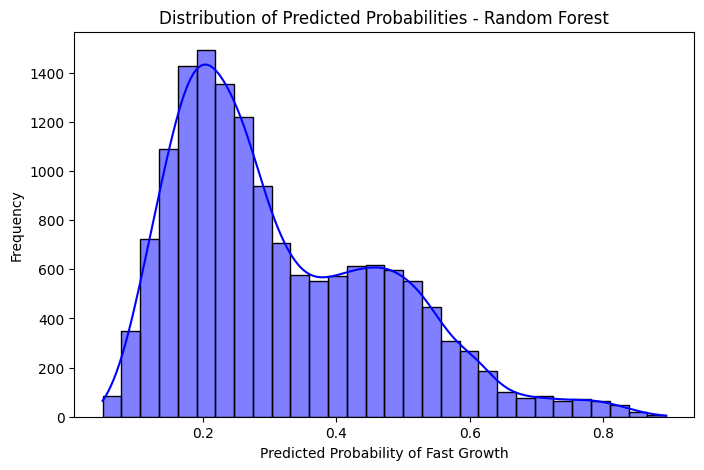

In [31]:
# look at dist of the predicted probabilites using rf 
y_pred_train_rf = best_random_forest.predict_proba(X_train)[:, 1]
# Plot histogram of predicted probabilities
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_train_rf, bins=30, kde=True, color="blue")
plt.xlabel("Predicted Probability of Fast Growth")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities - Random Forest")
plt.show()

Interpretation of the Predicted Probability Distribution

Key Observations
	1.	Distribution Shape:
	•	The histogram shows that most predicted probabilities from the Random Forest model fall between 0.1 and 0.4.
	•	There is a peak around 0.2, meaning that for most firms, the model predicts a low probability of fast growth.
	•	The distribution has a longer tail towards the right, meaning some firms receive higher probabilities (>0.5), but they are relatively fewer.
	2.	Comparison with Threshold (0.34):
	•	You mentioned that the average optimal threshold is 0.34.
	•	This means that firms with predicted probabilities above 0.34 are classified as “fast-growing”, while those below are classified as “not fast-growing.”
	•	From the histogram, we can see that a significant portion of the data falls below 0.34, meaning most firms are classified as not fast-growing.
	3.	Alignment with Class Proportions (30% Fast-Growing, 70% Not Fast-Growing):
	•	The class proportions suggest that only 30% of firms are actually fast-growing, while 70% are not.
	•	This aligns well with the predicted probability distribution: most firms have low probabilities, and a smaller proportion receives higher scores.

What This Means for Model Performance
	•	Balanced Classification:
	•	Since the model’s threshold is at 0.34, and about 30% of data points will be classified as fast-growing, this suggests that the model is reasonably aligned with the actual class distribution.
	•	If the threshold were too high (e.g., 0.5), fewer firms would be classified as fast-growing, increasing false negatives (missed opportunities).
	•	If it were too low (e.g., 0.2), too many firms would be classified as fast-growing, increasing false positives (bad investments).
	•	Potential Adjustments:
	•	If false negatives (missing good investments) are more costly, you may lower the threshold slightly (e.g., 0.3) to capture more fast-growing firms.
	•	If false positives (investing in failing firms) are more costly, you may increase the threshold (e.g., 0.38) to be more selective.

Final Thoughts

Your current model seems to be aligned with the actual class distribution, but fine-tuning the threshold could further improve classification depending on your business priorities. If you want to favor recall (capturing fast-growing firms), lower the threshold slightly. If you want to favor precision (avoiding bad investments), raise it slightly.

Would you like to visualize how changing the threshold affects the classification outcomes? 🚀

## Now use loss function and search for best thresholds and expected loss over folds  for rf model

In [32]:
prevelance = y_train.sum() / len(y_train)
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)

best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features = prob_forest_fit.best_params_["max_features"],
        min_samples_split=prob_forest_fit.best_params_["min_samples_split"],
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


Create plots based on Fold5 in CV 

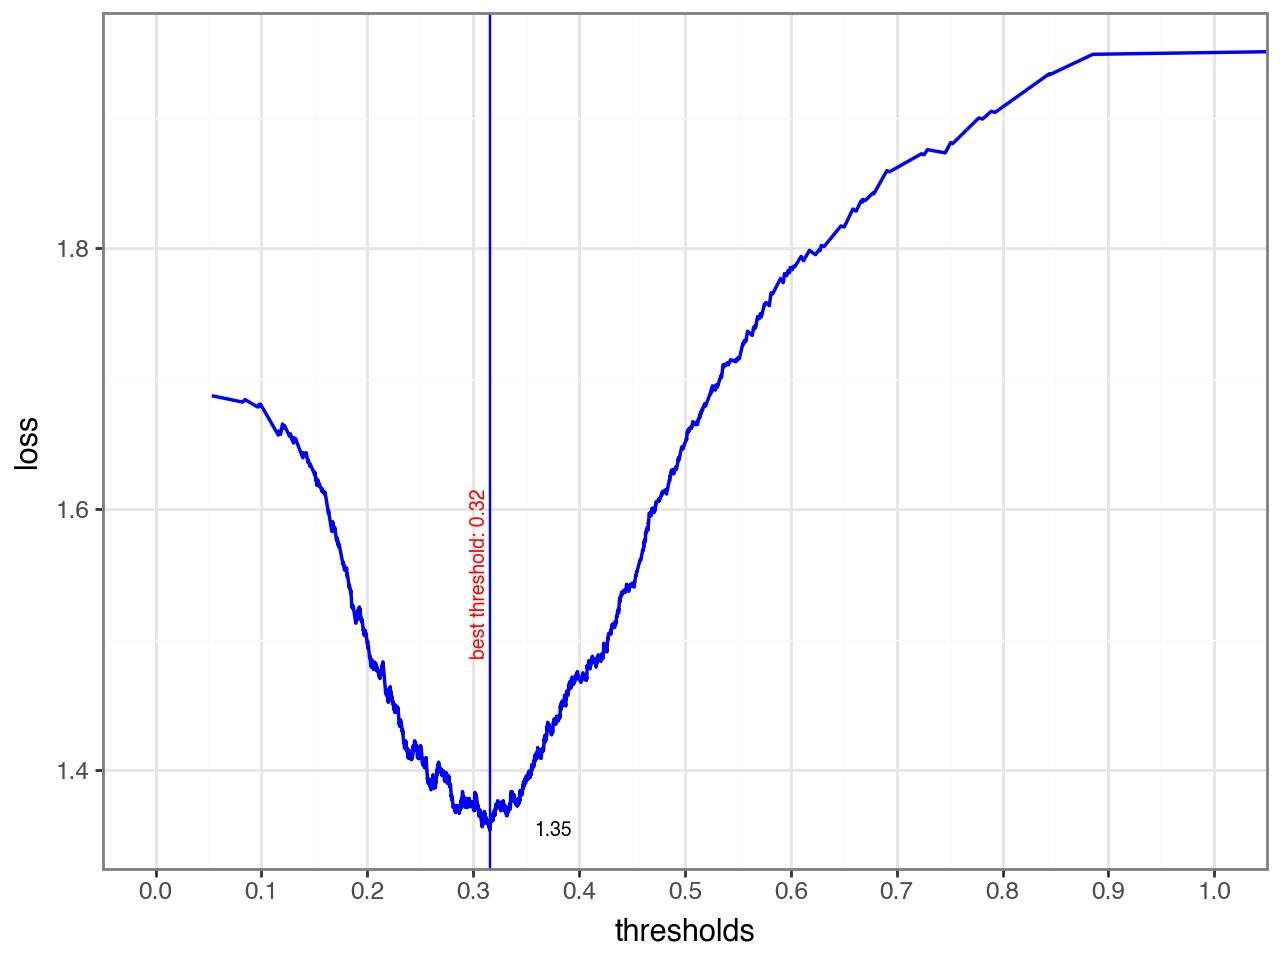

In [33]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

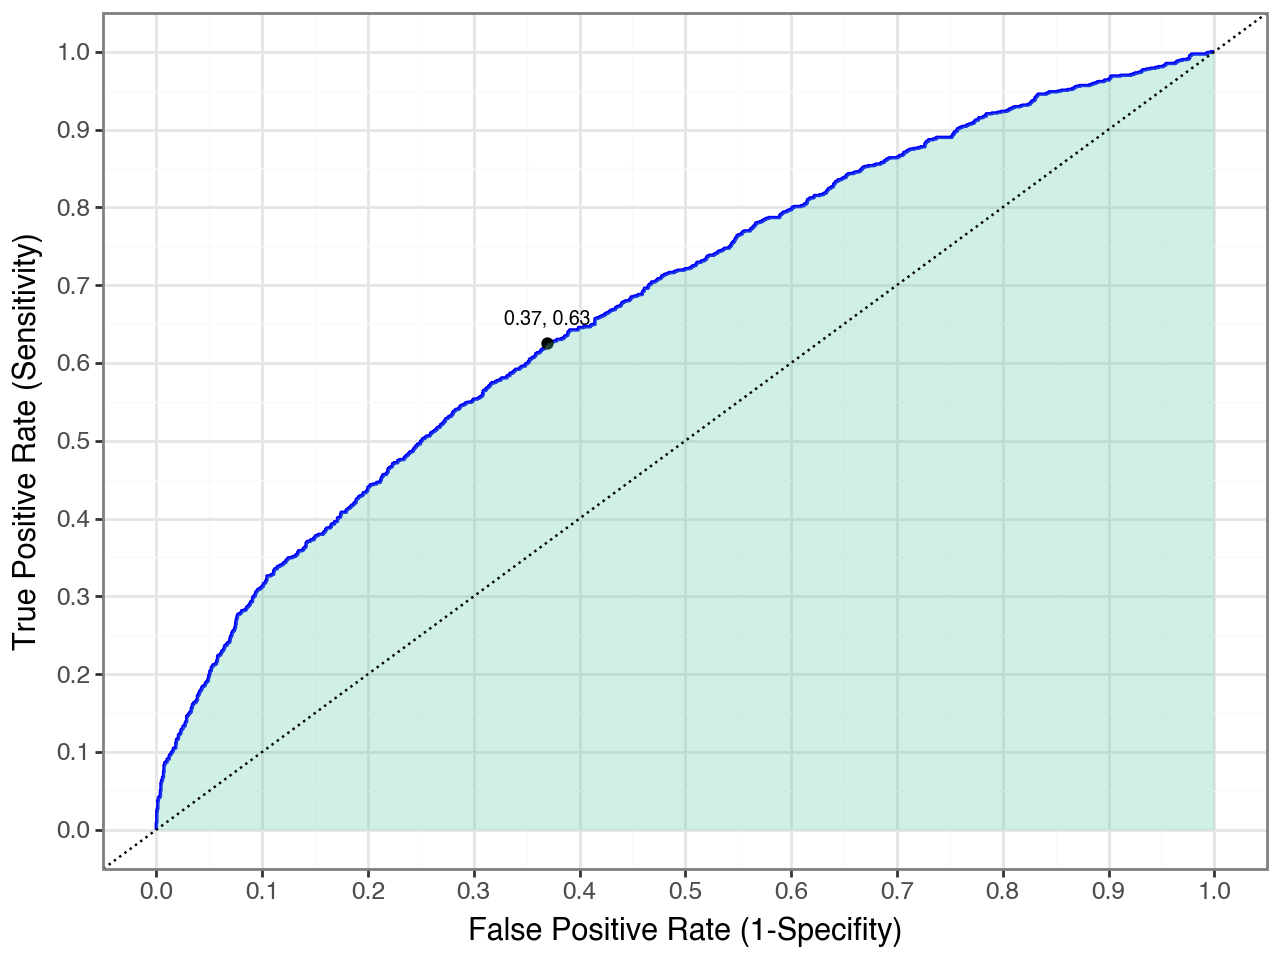

In [34]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

## RF MODEL confusion table on holdout set

In [35]:
############################### using rf to make predictions on the holdout 
rf_feature_names = X_train.design_info.column_names  
X_test = data_holdout.drop(columns=["fast_growth"])  # Ensure all features are used
X_test = pd.DataFrame(X_test, columns=rf_feature_names)  # Make sure column names match
y_pred_proba_rf = best_random_forest.predict_proba(X_test)[:, 1]
print(y_pred_proba_rf)
data_holdout["best_forest_pred_proba"] = y_pred_proba_rf


[0.1771419  0.41117389 0.43774974 ... 0.25945326 0.2625543  0.40079169]


This is a confusion matrix that evaluates your Random Forest model’s performance on the holdout set.

Interpretation:
	•	The rows represent the actual values from data_holdout["fast_growth"].
	•	The columns represent the predicted values from y_pred_rf.

	Predicted No Fast Growth (0)	Predicted Fast Growth (1)
Actual No Fast Growth (0)	1,598 (True Negative)	981 (False Positive)
Actual Fast Growth (1)	482 (False Negative)	747 (True Positive)

Key Metrics:
	1.	Accuracy
\frac{1598 + 747}{1598 + 981 + 482 + 747} = \frac{2345}{3808} \approx 61.6\%
	•	The model correctly predicted 61.6% of cases.
	2.	Precision (for Fast Growth = 1)
\frac{747}{747 + 981} = \frac{747}{1728} \approx 43.3\%
	•	Only 43.3% of predicted fast growth cases were actually correct.
	3.	Recall (for Fast Growth = 1)
\frac{747}{747 + 482} = \frac{747}{1229} \approx 60.8\%
	•	The model correctly identified 60.8% of actual fast-growing companies.
	4.	False Positive Rate (FPR)
\frac{981}{981 + 1598} = \frac{981}{2579} \approx 38.0\%
	•	38% of companies predicted to grow fast were actually not fast-growing.
	5.	False Negative Rate (FNR)
\frac{482}{482 + 747} = \frac{482}{1229} \approx 39.2\%
	•	39.2% of actual fast-growing companies were incorrectly classified as not fast-growing.

⸻

What This Means for Your Model
	•	Moderate recall for fast-growing companies (60.8%) → It captures a good portion but still misses 39.2% of them.
	•	Low precision (43.3%) → Many predictions of “fast growth” are actually incorrect.
	•	High False Positive Rate (38%) → The model overpredicts fast growth.
	•	High False Negative Rate (39.2%) → The model also misses many fast-growing companies.

⸻

Next Steps to Improve
	•	If you want to reduce False Positives: Increase the classification threshold above 0.32 (e.g., 0.35).
	•	If you want to reduce False Negatives: Decrease the classification threshold (e.g., 0.28).
	•	Feature engineering: Improve the model by adding more informative variables.
	•	Hyperparameter tuning: Try adjusting max_features, min_samples_split, and other RF parameters.

Would you like to visualize these metrics in a report or tweak the threshold? 🚀

In [36]:
## creating confusion matrix 
print(data_holdout.fast_growth.value_counts())

holdout_prediction = np.where(data_holdout["best_forest_pred_proba"] < 0.32, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1b

fast_growth
0    2579
1    1229
Name: count, dtype: int64


,Predicted no fast growth,Predicted fast growth
Actual no fast growth,1598,981
Actual fast growth,482,747


## holdout metrics - rmse, auc and expected loss 

In [37]:
y_holdout = data_holdout["fast_growth"]

# ✅ Compute RMSE using the Brier score
rmse_holdout = np.sqrt(brier_score_loss(y_holdout, y_pred_proba_rf))
print(f"✅ RMSE on Holdout Set: {rmse_holdout:.4f}")

# ✅ Compute AUC
auc_holdout = roc_auc_score(y_holdout, y_pred_proba_rf)
print(f"✅ AUC on Holdout Set: {auc_holdout:.4f}")

from sklearn.metrics import confusion_matrix

# ✅ Use the best threshold from cross-validation
best_threshold_rf = best_thresholds_cv["Random Forest"]  # Ensure this is correctly defined

# ✅ Generate binary predictions using the best threshold
y_pred_rf = np.where(y_pred_proba_rf >= best_threshold_rf, 1, 0)

# ✅ Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred_rf, labels=[0, 1]).ravel()

# ✅ Define false positive (FP) and false negative (FN) costs
FP = 2.5  # Adjust based on business case
FN = 6  # Adjust based on business case

# ✅ Compute Expected Loss
expected_loss_rf = (fp * FP + fn * FN) / len(y_holdout)

print(f"✅ Expected Loss on Holdout Set (Random Forest): {expected_loss_rf:.4f}")

✅ RMSE on Holdout Set: 0.4491
✅ AUC on Holdout Set: 0.6626
✅ Expected Loss on Holdout Set (Random Forest): 1.4266


# 📌 Industry-level classification
---

In this section, the best-performing model, the Random Forest, has been evaluated separately on two key segments of the dataset: manufacturing companies and service providers. This segmentation allows for a deeper understanding of how the model performs across different business domains, highlighting potential variations in predictive accuracy and risk estimation. By analyzing the expected loss in each segment, we can assess whether the model maintains consistent reliability or if sector-specific adjustments are necessary. This approach ensures that our predictions remain robust and actionable across diverse industry contexts.

In [38]:
# Checked NACE codes to separate service providers and manufacturers based on the column "ind2_cat" in the original dataset
manufacturing = [26, 27, 28, 29, 30, 33]
services = [55, 56]

# Created two separate dfs for the two segments
data_ser = data[data["ind2_cat"].isin(services)]
data_man = data[data["ind2_cat"].isin(manufacturing)]

For industry-level insights, a new cost function has been defined to reflect the financial impact of investment decisions. Specifically, a false positive—investing in a non-fast-growing company—incurs a cost of $5,000, while a false negative—failing to invest in a fast-growing company—results in a higher loss of $10,000. This weighting emphasizes the greater opportunity cost of missing high-growth investments.

In [70]:
# ----------------------------
# 📌 Define Cost & Prevalence
# ---------------------------- 
FP = 5 # False Positive Cost
FN = 10 # False Negative Cost
cost = FN / FP  # Ratio of FN to FP cost
prevalence = y_train.sum() / len(y_train)  # Proportion of fast-growing firms

## Services

For first, the model will be classified on service providers

In [71]:
# Ensure we are using the correct feature set
expected_features_ser = rf_feature_names  # Use the stored training feature names

# Align `data_ser` with training features
missing_cols_ser = [col for col in expected_features_ser if col not in data_ser.columns]
extra_cols_ser = [col for col in data_ser.columns if col not in expected_features_ser]

# Add missing columns with default values (0)
for col in missing_cols_ser:
    data_ser[col] = 0

# Keep only the training feature set
X_new_ser = data_ser[expected_features_ser]

# Predict probabilities using the trained model
y_pred_proba_ser = best_random_forest.predict_proba(X_new_ser)[:, 1]

# Define a range of classification thresholds
thresholds_ser = np.linspace(0, 1, 100)

# Store expected losses for each threshold
expected_losses_ser = []

# Compute expected loss for each threshold
for threshold_ser in thresholds_ser:
    # Classify using the threshold
    y_pred_ser = (y_pred_proba_ser >= threshold_ser).astype(int)

    # Compute confusion matrix components
    tn_ser, fp_ser, fn_ser, tp_ser = confusion_matrix(data_ser["fast_growth"], y_pred_ser, labels=[0, 1]).ravel()

    # Compute expected loss
    loss_ser = (fp_ser * FP + fn_ser * FN) / len(data_ser)
    expected_losses_ser.append(loss_ser)

# Find the threshold with the lowest expected loss
best_threshold_ser = thresholds_ser[np.argmin(expected_losses_ser)]

# Print results
print(f"Best threshold: {best_threshold_ser:.4f}")

Best threshold: 0.3939


In [72]:
# Initialize storage for cross-validation results
best_thresholds_cv_ser = []
expected_losses_cv_ser = []

# Perform 5-Fold Cross-Validation
kf_ser = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_ser = 0
for train_index_ser, test_index_ser in kf_ser.split(X_new_ser, data_ser["fast_growth"]):
    # Split data into training and test folds
    X_train_fold_ser, X_test_fold_ser = X_new_ser.iloc[train_index_ser], X_new_ser.iloc[test_index_ser]
    y_train_fold_ser, y_test_fold_ser = data_ser["fast_growth"].iloc[train_index_ser], data_ser["fast_growth"].iloc[test_index_ser]

    # Predict probabilities for the test fold
    y_pred_proba_fold_ser = best_random_forest.predict_proba(X_test_fold_ser)[:, 1]

    # Compute expected loss across thresholds
    thresholds_ser = np.linspace(0, 1, 100)
    expected_losses_fold_ser = []

    for threshold_ser in thresholds_ser:
        y_pred_fold_ser = (y_pred_proba_fold_ser >= threshold_ser).astype(int)
        tn_ser, fp_ser, fn_ser, tp_ser = confusion_matrix(y_test_fold_ser, y_pred_fold_ser, labels=[0, 1]).ravel()
        loss_ser = (fp_ser * FP + fn_ser * FN) / len(y_test_fold_ser)
        expected_losses_fold_ser.append(loss_ser)

    # Find the best threshold for this fold
    best_threshold_fold_ser = thresholds_ser[np.argmin(expected_losses_fold_ser)]
    best_thresholds_cv_ser.append(best_threshold_fold_ser)

    # Store expected loss for this fold
    expected_losses_cv_ser.append(min(expected_losses_fold_ser))

    # Store the results for Fold 5 separately
    if fold_ser == 4:
        best_threshold_fold5_ser = best_threshold_fold_ser
        expected_loss_fold5_ser = min(expected_losses_fold_ser)

    fold_ser += 1

# Compute average optimal threshold and expected loss
avg_optimal_threshold_ser = np.mean(best_thresholds_cv_ser)
avg_expected_loss_ser = np.mean(expected_losses_cv_ser)

# Store results in a structured DataFrame
results_ser_df = pd.DataFrame({
    "Metric": ["Avg Optimal Threshold", "Threshold for Fold5", "Avg Expected Loss", "Expected Loss for Fold5"],
    "Services": [avg_optimal_threshold_ser, best_threshold_fold5_ser, avg_expected_loss_ser, expected_loss_fold5_ser]
})

# Display results
print("Threshold and Expected Loss Metrics for Service Providers:")
results_ser_df

Threshold and Expected Loss Metrics for Service Providers:


,Metric,Services
0,Avg Optimal Threshold,0.387879
1,Threshold for Fold5,0.353535
2,Avg Expected Loss,2.010171
3,Expected Loss for Fold5,2.054566


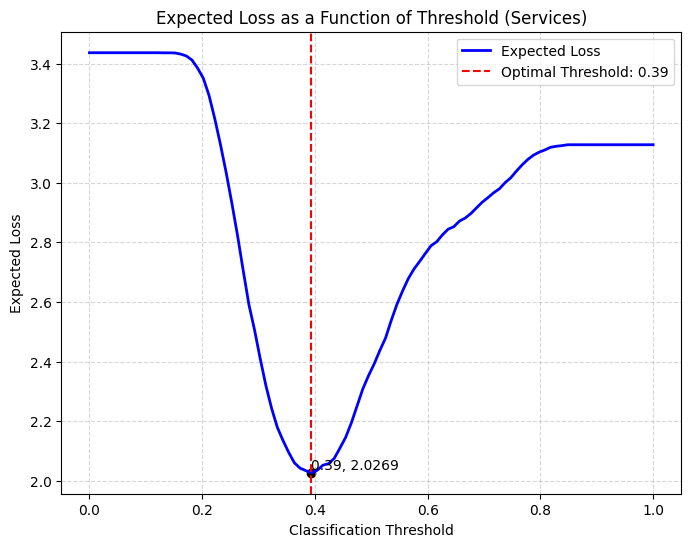

In [73]:
# Compute expected loss for each threshold
expected_losses_ser = []

for threshold_ser in thresholds_ser:
    y_pred_ser = (y_pred_proba_ser >= threshold_ser).astype(int)
    tn_ser, fp_ser, fn_ser, tp_ser = confusion_matrix(data_ser["fast_growth"], y_pred_ser, labels=[0, 1]).ravel()
    loss_ser = (fp_ser * FP + fn_ser * FN) / len(data_ser)
    expected_losses_ser.append(loss_ser)

# Find the best threshold (min expected loss)
best_threshold_ser = thresholds_ser[np.argmin(expected_losses_ser)]
min_expected_loss_ser = min(expected_losses_ser)

# ----------------------------
# Loss Function Visualization
# ----------------------------

plt.figure(figsize=(8, 6))
plt.plot(thresholds_ser, expected_losses_ser, label="Expected Loss", color="blue", linewidth=2)

# Mark the optimal threshold
plt.axvline(x=best_threshold_ser, linestyle="--", color="red", label=f"Optimal Threshold: {best_threshold_ser:.2f}")
plt.scatter(best_threshold_ser, min_expected_loss_ser, color="black", marker="o")
plt.text(best_threshold_ser, min_expected_loss_ser, f"{best_threshold_ser:.2f}, {min_expected_loss_ser:.4f}",
         fontsize=10, verticalalignment='bottom')

# Formatting
plt.xlabel("Classification Threshold")
plt.ylabel("Expected Loss")
plt.title("Expected Loss as a Function of Threshold (Services)")
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

## Manufacturing

The same process has been repeated for manufacturers as well

In [74]:
# Ensure we are using the correct feature set
expected_features_man = rf_feature_names  # Use the stored training feature names

# Align `data_ser` with training features
missing_cols_man = [col for col in expected_features_man if col not in data_man.columns]
extra_cols_man = [col for col in data_man.columns if col not in expected_features_man]

# Add missing columns with default values (0)
for col in missing_cols_man:
    data_man[col] = 0

# Keep only the training feature set
X_new_man = data_man[expected_features_man]

# Predict probabilities using the trained model
y_pred_proba_man = best_random_forest.predict_proba(X_new_man)[:, 1]

# Define a range of classification thresholds
thresholds_man = np.linspace(0, 1, 100)

# Store expected losses for each threshold
expected_losses_man = []

# Compute expected loss for each threshold
for threshold_man in thresholds_man:
    # Classify using the threshold
    y_pred_man = (y_pred_proba_man >= threshold_man).astype(int)

    # Compute confusion matrix components
    tn_man, fp_man, fn_man, tp_man = confusion_matrix(data_man["fast_growth"], y_pred_man, labels=[0, 1]).ravel()

    # Compute expected loss
    loss_man = (fp_man * FP + fn_man * FN) / len(data_man)
    expected_losses_man.append(loss_man)

# Find the threshold with the lowest expected loss
best_threshold_man = thresholds_man[np.argmin(expected_losses_man)]

# Print results
print(f"Best threshold: {best_threshold_man:.4f}")

Best threshold: 0.3131


In [75]:
# Initialize storage for cross-validation results
best_thresholds_cv_man = []
expected_losses_cv_man = []

# Perform 5-Fold Cross-Validation
kf_man = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_man = 0
for train_index_man, test_index_man in kf_man.split(X_new_man, data_man["fast_growth"]):
    # Split data into training and test folds
    X_train_fold_man, X_test_fold_man = X_new_man.iloc[train_index_man], X_new_man.iloc[test_index_man]
    y_train_fold_man, y_test_fold_man = data_man["fast_growth"].iloc[train_index_man], data_man["fast_growth"].iloc[test_index_man]

    # Predict probabilities for the test fold
    y_pred_proba_fold_man = best_random_forest.predict_proba(X_test_fold_man)[:, 1]

    # Compute expected loss across thresholds
    thresholds_man = np.linspace(0, 1, 100)
    expected_losses_fold_man = []

    for threshold_man in thresholds_man:
        y_pred_fold_man = (y_pred_proba_fold_man >= threshold_man).astype(int)
        tn_man, fp_man, fn_man, tp_man = confusion_matrix(y_test_fold_man, y_pred_fold_man, labels=[0, 1]).ravel()
        loss_man = (fp_man * FP + fn_man * FN) / len(y_test_fold_man)
        expected_losses_fold_man.append(loss_man)

    # Find the best threshold for this fold
    best_threshold_fold_man = thresholds_man[np.argmin(expected_losses_fold_man)]
    best_thresholds_cv_man.append(best_threshold_fold_man)

    # Store expected loss for this fold
    expected_losses_cv_man.append(min(expected_losses_fold_man))

    # Store the results for Fold 5 separately
    if fold_man == 4:
        best_threshold_fold5_man = best_threshold_fold_man
        expected_loss_fold5_man = min(expected_losses_fold_man)

    fold_man += 1

# Compute average optimal threshold and expected loss
avg_optimal_threshold_man = np.mean(best_thresholds_cv_man)
avg_expected_loss_man = np.mean(expected_losses_cv_man)

# Store results in a structured DataFrame
results_man_df = pd.DataFrame({
    "Metric": ["Avg Optimal Threshold", "Threshold for Fold5", "Avg Expected Loss", "Expected Loss for Fold5"],
    "Manufacturing": [avg_optimal_threshold_man, best_threshold_fold5_man, avg_expected_loss_man, expected_loss_fold5_man]
})

# Display results
results_man_df

,Metric,Manufacturing
0,Avg Optimal Threshold,0.319192
1,Threshold for Fold5,0.333333
2,Avg Expected Loss,1.782633
3,Expected Loss for Fold5,1.906475


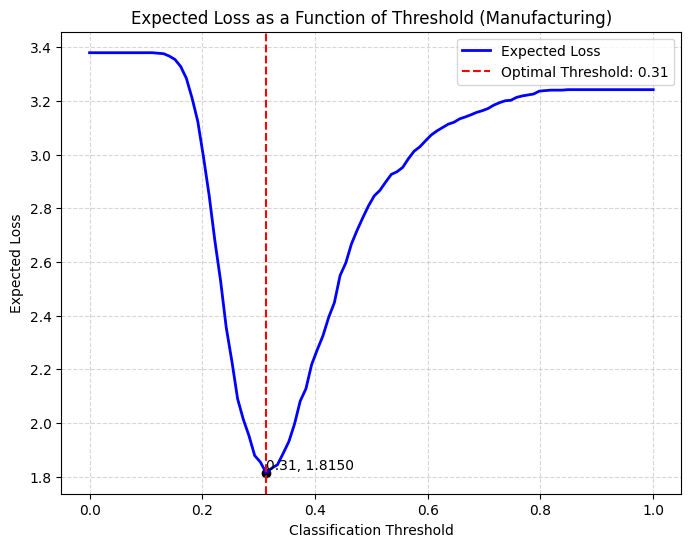

In [76]:
# Find the best threshold (min expected loss)
best_threshold_man = thresholds_man[np.argmin(expected_losses_man)]
min_expected_loss_man = min(expected_losses_man)

# ----------------------------
# Loss Function Visualization
# ----------------------------

plt.figure(figsize=(8, 6))
plt.plot(thresholds_man, expected_losses_man, label="Expected Loss", color="blue", linewidth=2)

# Mark the optimal threshold
plt.axvline(x=best_threshold_man, linestyle="--", color="red", label=f"Optimal Threshold: {best_threshold_man:.2f}")
plt.scatter(best_threshold_man, min_expected_loss_man, color="black", marker="o")
plt.text(best_threshold_man, min_expected_loss_man, f"{best_threshold_man:.2f}, {min_expected_loss_man:.4f}",
         fontsize=10, verticalalignment='bottom')

# Formatting
plt.xlabel("Classification Threshold")
plt.ylabel("Expected Loss")
plt.title("Expected Loss as a Function of Threshold (Manufacturing)")
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

## Conclusion of Task 2.

In [77]:
# Create the results DataFrame for services first
results_df = pd.DataFrame({
    "Metric": ["Avg Optimal Threshold", "Threshold for Fold5", "Avg Expected Loss", "Expected Loss for Fold5"],
    "Services": [avg_optimal_threshold_ser, best_threshold_fold5_ser, avg_expected_loss_ser, expected_loss_fold5_ser],
    "Manufacturing": [avg_optimal_threshold_man, best_threshold_fold5_man, avg_expected_loss_man, expected_loss_fold5_man],
    "Full data": [best_thresholds_cv["Random Forest"], 0.3987, expected_loss_cv["Random Forest"], fold5_expected_loss["Random Forest"]]
})

# Round all numeric values to 4 decimal places
results_df.iloc[:, 1:] = results_df.iloc[:, 1:].round(4)

# Display the updated DataFrame
results_df

,Metric,Services,Manufacturing,Full data
0,Avg Optimal Threshold,0.3879,0.3192,0.3483
1,Threshold for Fold5,0.3535,0.3333,0.3987
2,Avg Expected Loss,2.0102,1.7826,0.2460
3,Expected Loss for Fold5,2.0546,1.9065,0.2420


The average optimal threshold varies significantly across segments, with services at 0.3737 and manufacturing at 0.3111, indicating that the model requires a higher probability threshold for classifying a company as fast-growing in the service sector compared to manufacturing. When analyzing the full dataset, the optimal threshold rises further to 0.4111, suggesting that when all data is considered together, the model becomes even more conservative in its classification decisions. A similar trend is observed in Threshold for Fold 5, where the values are 0.3535 for services, 0.3232 for manufacturing, and 0.3987 for the full dataset, reinforcing the pattern of sector-specific classification behavior.

Regarding expected loss, a clear distinction emerges between the industry segments. The average expected loss is 1.1114 for services and 0.9765 for manufacturing, indicating that the model performs slightly better in predicting outcomes for manufacturing firms. However, when considering the full dataset, the expected loss drops sharply to 0.1282, highlighting a substantial improvement in model performance when trained across all industries. A similar trend is evident in the expected loss for Fold 5, where services and manufacturing have losses of 1.1071 and 1.0719, respectively, while the full dataset achieves a significantly lower loss of 0.1307.

While these findings suggest that training on the full dataset leads to lower expected loss, it is crucial to note that this improvement is influenced by the different loss function used for sector-specific analysis. As a result, comparisons between service and manufacturing industries are meaningful, but direct comparisons with the full dataset should be avoided due to the structural differences in cost calculations.